# Demo series: Controllers & Agents

---

## Active Inference for controlling a driven damped harmonic oscillator

Wouter Kouw, last update: 10-09-2021

### System

This project considers a [harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator#Driven_harmonic_oscillators). Consider a position $x(t)$ and a driving force $u(t)$. The continuous-time dynamics of the system are:

$$\begin{align*}
m \frac{d^2 x(t)}{dt^2} =&\ - c \frac{d x(t)}{dt} - k x(t) + u(t) \, ,
\end{align*}$$
where 
$$
m     = \text{mass} \, , \quad
c     = \text{damping} \, , \quad
k     = \text{spring stiffness} 
$$
constitute the physical parameters. 

#### First-order system in generalised coordinates

We will first adopt a more concise notation and then divide by the leading coefficient:

$$ x'' = \frac{-c}{m} x' + \frac{-k}{m} x + \frac{1}{m} u \, .$$

In this demo, we will make the following variable substitutions:

$$ \theta_1 = \frac{-k}{m} \, , \quad \theta_2 = \frac{-c}{m} \, , \quad \eta = \frac{1}{m} \, ,$$

with which we cast the above system into a multi-variate first-order form:

$$ \underbrace{\begin{bmatrix} x' \\ x'' \end{bmatrix}}_{z'} = \begin{bmatrix} 0 & 1 \\ \theta_1 & \theta_2 \end{bmatrix}  \begin{bmatrix} x \\ x' \end{bmatrix} + \begin{bmatrix} 0 \\ \eta \end{bmatrix} u \, .$$

A simple discretization yields:

$$\begin{align*} 
\left( \begin{bmatrix} x_{k+1} \\ x'_{k+1} \end{bmatrix} - \begin{bmatrix} x_{k} \\ x'_{k} \end{bmatrix} \right) / \Delta t =&\ \begin{bmatrix} 0 & 1 \\ \theta_1 & \theta_2 \end{bmatrix} \begin{bmatrix} x_k \\ x'_k \end{bmatrix} + \begin{bmatrix} 0 \\ \eta \end{bmatrix} u_k \, ,
\end{align*}$$

which can be re-arranged to produce:

$$\begin{align*}
\begin{bmatrix} x_{k+1} \\ x'_{k+1} \end{bmatrix} =&\ \underbrace{\begin{bmatrix} 1 & \Delta t \\ \theta_1 \Delta t & \theta_2 \Delta t + 1 \end{bmatrix}}_{A(\theta)} \begin{bmatrix} x_k \\ x'_k \end{bmatrix} + \underbrace{\begin{bmatrix} 0 \\ \eta \Delta t \end{bmatrix}}_{B(\eta)} u_k \, .
\end{align*}$$

In [2]:
using Revise
using LinearAlgebra
using Colors
using ProgressMeter
using Optim

In [6]:
using ForneyLab
using GFX
include("util.jl");

In [7]:
using Plots
default(label="", grid=false, linewidth=4, margins=10Plots.pt)

In [109]:
# Sampling step size
Δt = 0.1

# Physical parameters
m = 8.0
c = 2.0
k = 4.0

# Report damping ratio
ζ = c/(2*sqrt(m*k))
println("Damping ratio ζ = "*string(ζ))

# Report natural frequency
ωn = sqrt(k/m)
println("Natural frequency ω_n = "*string(ωn))

Damping ratio ζ = 0.17677669529663687
Natural frequency ω_n = 0.7071067811865476


In [110]:
# Define coefficient matrices
A(θ) = [1. Δt; 0. 1.] + [0., Δt]*θ'
B(η) = [0., Δt]*η
C = [1, 0]'

# State transition coefficients
θ1 = -k/m
θ2 = -c/m
θ_true = [θ1, θ2]

# Control coefficient
η_true = 1/m

function sim_ddho(input, z_kmin1, params)
   "Simulate driven damped harmonic oscillator"
    
    # Unpack parameters
    θ, η = params
    
    return A(θ)*z_kmin1 + B(η)*input
end;

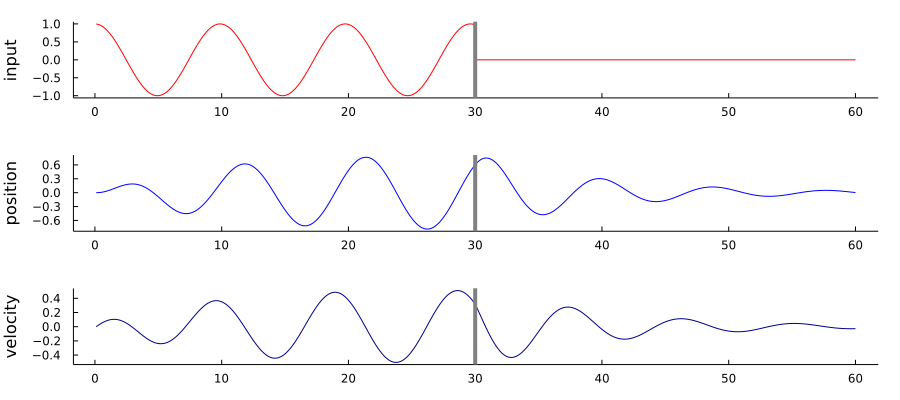

In [111]:
# Time 
T = 600
t = Δt.*(1:T)
stop = T-300

# Input signal
input = [cos.(Δt .*(1:stop)* 2/π); zeros(length(stop+1:T),)]

# Simulate system
states = zeros(T,2)
for k = 2:T
    states[k,:] = sim_ddho(input[k], states[k-1,:], (θ_true, η_true))
end

p101 = plot(t, input, linewidth=1, color="red", ylabel="input", label="")
vline!([Δt.*stop], color="gray", label="")

p102 = plot(t, states[:,1], linewidth=1, color="blue", ylabel="position", label="")
vline!([Δt.*stop], color="gray", label="")

p103 = plot(t, states[:,2], linewidth=1, color="darkblue", ylabel="velocity", label="")
vline!([Δt.*stop], color="gray", label="")

p100 = plot(p101, p102, p103, layout=(3,1), size=(900,400))

#### Noise

Our system will be perturbed by external disturbances, expressed through a process noise variable. We will adopt a Gaussian distributed noise $w_k \sim \mathcal{N}\big(0, Q(\tau)\big)$ with the following structured covariance matrix:

$$Q(\tau) = \tau^{-1} \begin{bmatrix} \frac{1}{3} \Delta t^3 & \frac{1}{2} \Delta t^2 \\ \frac{1}{2} \Delta t^2 & \Delta t \end{bmatrix}$$ 

The notation $\mathcal{N}(m,S)$ is shorthand for a Gaussian (Normal) distribution with mean $m$ and covariance matrix $S$. The scalar parameter $\tau$ is an unknown variable that will need to be estimated. It represents [precision](https://en.wikipedia.org/wiki/Precision_%28statistics%29) instead of variance, which is useful in a Bayesian inference setting.

Now suppose we observe the oscillator's position through a noisy sensor
$$\begin{align*}
y_k =&\ C x_k + e_k \, ,
\end{align*}$$

where $C$ is a masking vector $\begin{bmatrix} 1 & 0 \end{bmatrix}$ and $e_k$ represents Gaussian distributed measurement noise: $e_k \sim \mathcal{N}(0, \xi^{-1})$. For now, we assume that the measurement precision parameter $\xi$ is known.

Overall, we obtain the following discrete-time state-space model:

$$\begin{align*} 
z_{k} =&\ A(\theta) z_{k-1} + B(\eta) u_k + w_k\\
y_k =&\ Cz_k + e_k \, .
\end{align*}$$

In [112]:
# Measurement noise precision
ξ_true = 1e8

# Process noise precision
τ_true = 1e6

# Define structured covariance matrix
Q(τ) = inv(τ)*[Δt^3/3 Δt^2/2; Δt^2/2 Δt]

# Pack variables
sys_params = (θ_true, η_true, τ_true, ξ_true)

([-0.5, -0.25], 0.125, 1.0e6, 1.0e8)

In [113]:
function sim_sys(input, z_kmin1, params)
   "Simulate dynamic system"
    
    # Unpack parameters
    θ, η, τ, ξ = params
    
    # Generate noises
    w_k = cholesky(Q(τ)).U*randn(2,)
    e_k = sqrt(inv(ξ))*randn(1,)[1]
    
    # State transition
    z_k = A(θ)*z_kmin1 + B(η)*input + w_k
    
    # Generate observation
    y_k = C*z_k + e_k
    
    return y_k, z_k    
end;

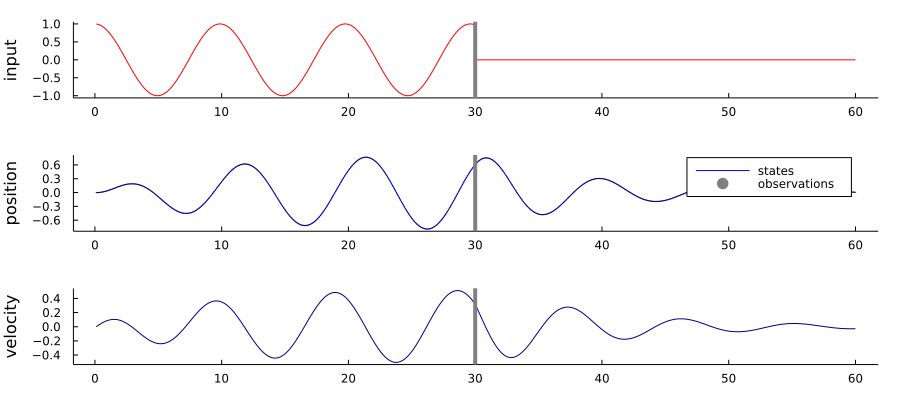

In [114]:
# Time 
T = 600
stop = T-300

# Input signal
input = [cos.(Δt .*(1:stop)* 2/π); zeros(length(stop+1:T),)]

# Simulate system
states = zeros(T,2)
output = zeros(T,1)
for k = 2:T
    output[k], states[k,:] = sim_sys(input[k], states[k-1,:], sys_params)
end

p201 = plot(t, input, linewidth=1, color="red", ylabel="input", label="")
vline!([Δt.*stop], color="gray", label="")

p202 = plot(t, states[:,1], linewidth=1, color="blue", ylabel="position", label="states")
scatter!(t, output, markersize=1, alpha=0.5, color="black", ylabel="position", label="observations")
vline!([Δt.*stop], color="gray", label="")

p203 = plot(t, states[:,2], linewidth=1, color="darkblue", ylabel="velocity", label="")
vline!([Δt.*stop], color="gray", label="")

p200 = plot(p201, p202, p203, layout=(3,1), size=(900,400))

## Probabilistic model

In specifying a probabilistic model, we need to establish a likelihood, pose priors for unknown variables and designate how we may obtain posteriors.

### Likelihood

In order to establish a likelihood function, we need to express the observation $y_k$ as coming from a probability distribution. This can be done by integrating over the noise variable $e_k$ with the deterministic function $y_k = Cz_k + e_k$ expressed as a Dirac delta distribution:

$$\begin{align*}
p(y_k \mid z_k) =&\ \int \delta( y_k - (Cz_k + e_k)) \mathcal{N}(e_k \mid 0, \xi^{-1}) \ \mathrm{d}e_k \\
=&\ \int \delta( (y_k - Cz_k) - e_k) \mathcal{N}(e_k \mid 0, \xi^{-1}) \ \mathrm{d}e_k \\
=&\ \mathcal{N}(y_k - Cz_k \mid 0, \xi^{-1}) \\
=&\ \mathcal{N}(y_k \mid C z_k, \xi^{-1}) \, .
\end{align*}$$

Note that the shorthand $\mathcal{N}$ adheres to a mean-variance parameterization and since $\xi$ is a precision parameter (inverse variance), it needs to be inverted. Further note that in the $p(\cdot)$ notation, only the observed and unknown variables are written. Terms set by the engineer, such as $C$ and $\xi$ are left out.

### State transition

In dynamic models, we must also cast the state's transition dynamics to probabilistic form. We can use the same formula to re-express $z_k$. Recalling that $w_k \sim \mathcal{N}\big(0, Q(\tau)\big)$, the state transition can be written probabilistically as:

$$p(z_k | z_{k-1}, \theta, \eta, \tau) = \mathcal{N}\big(z_k \mid A(\theta) z_{k-1} + B(\eta) u_k , Q(\tau) \big) \, .$$

The control variable $u_k$ will be set through a different procedure and is therefore not part of $p(z_k | z_{k-1}, \theta, \eta, \tau)$.

### Priors

We choose Gaussian priors for the unknown coefficients and a Gamma prior for the unknown process noise precision:

$$\begin{align*}
p(\theta) = \mathcal{N}(m^{0}_{\theta}, V^{0}_{\theta}) \, , \quad 
p(\eta) = \mathcal{N}(m^{0}_{\eta}, v^{0}_{\eta}) \, , \quad  
p(\tau)= \Gamma(a^{0}_\tau, b^{0}_\tau) \, .
\end{align*}$$

We also need a prior distribution for the initial state: 

$$ p(z_0) = \mathcal{N}(m_{z_0}, V_{z_0}) \, .$$ 

This corresponds to the set of initial conditions in the differential equation, with added uncertainty. 

Overall, if we consider a time-series from $k=1$ to $T$, then our probabilistic model could be written as:

$$\underbrace{p(y_{1:T}, z_{0:T}, \theta, \eta, \tau)}_{\text{joint distribution}} = \underbrace{p(\theta)p(\eta)p(\tau)p(z_0)}_{\text{priors}} \ \prod_{k=1}^{T} \ \underbrace{p(y_k \mid z_k)}_{\text{likelihood}} \ \underbrace{p(z_k \mid z_{k-1}, \theta, \eta, \tau)}_{\text{state transition}} \, .$$

We can actually directly specify this probabilistic model in the toolbox [ForneyLab.jl](https://github.com/biaslab/ForneyLab.jl).

In [115]:
# Start model definition with a factor graph object
graph1 = FactorGraph()

# Coefficient priors
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(2,)), placeholder(:w_θ, dims=(2,2)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))

# Noise precision prior
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))

# State prior
@RV z_kmin1 ~ GaussianMeanPrecision(placeholder(:m_kmin1, dims=(2,)), placeholder(:w_kmin1, dims=(2, 2)), id=:z_kmin1)

# Custom state transition node
@RV z_k ~ GeneralisedFilterX(θ, z_kmin1, η, placeholder(:u_k), τ, Δt=Δt, id=:z_k)

# Likelihood of observation
@RV y_k ~ GaussianMeanPrecision(dot([1., 0.], z_k), ξ_true, id=:y_k)
placeholder(y_k, :y_k);

## Parameter and state estimation

Prior distributions should be interpreted as our "beliefs" over what values the unknown variables might take, _prior_ to observing data. Bayesian inference is about updating these beliefs _after_ observing data. We call these updated beliefs "posterior distributions". 

### Posteriors

We can obtain a posterior distribution through Bayes' theorem where we multiply the likelihood with the prior distributions to form a joint distribution and then normalize that joint by the "evidence" (marginal probability of observed data):

$$ \underbrace{p(z_{0:T}, \theta, \eta, \tau \mid y_{1:T})}_{\text{posterior}} = \frac{1}{\underbrace{p(y_{1:T})}_{\text{evidence}}} \ \underbrace{\overbrace{p(\theta)p(\eta)p(\tau)p(z_0)}^{\text{priors}} \ \prod_{k=1}^{T} \ \overbrace{p(y_k \mid z_k)}^{\text{likelihood}} \ \overbrace{p(z_k \mid z_{k-1}, \theta, \eta, \tau)}^{\text{transition}}}_{\text{joint}}$$

However, in order to compute this posterior we would need access to all data simultaneously. Instead, we are interested in a recursive formulation of the posterior distribution. The Bayesian filtering equations express posterior distributions recursively in terms of a prediction and an update step (Ch.4, [Särkkä, 2013](https://doi.org/10.1017/CBO9781139344203)). For the first time step $k=1$, the prediction equation corresponds to:

$$\underbrace{p(z_1, \theta, \eta, \tau)}_{\text{initial prediction}} = \int \underbrace{p(z_1 \mid z_0, \theta, \eta, \tau)}_{\text{state transition}} \ \underbrace{p(z_0) p(\theta) p(\eta) p(\tau)}_{\text{priors}} \ \mathrm{d}z_0$$

and the update (correction) equation corresponds to:

$$ \underbrace{p(z_1, \theta, \eta, \tau \mid y_1)}_{\text{initial posterior}} = \frac{1}{\underbrace{p(y_1)}_{\text{evidence}}} \ \underbrace{p(y_1 \mid z_1)}_{\text{likelihood}} \ \underbrace{p(z_1, \theta, \eta, \tau)}_{\text{initial prediction}} \, ,$$

where the evidence term is an (often troublesome) integration: $p(y_1) = \int p(y_1 \mid z_1) p(z_1, \theta, \eta, \tau) \ \mathrm{d}(z_1, \theta, \eta, \tau)$.

Generalizing towards $k>1$ is relatively straightforward. The prediction step corresponds to the state and parameter estimates given all previously observed data $y_{1:k-1}$:

$$\underbrace{p(z_k, \theta, \eta, \tau \mid y_{1:k-1})}_{\text{prediction for $k$}} = \int \underbrace{p(z_k \mid z_{k-1}, \theta, \eta, \tau)}_{\text{state transition}} \ \underbrace{p(z_{k-1}, \theta, \eta, \tau \mid y_{1:k-1})}_{\text{posterior at $k-1$}} \ \mathrm{d}z_{k-1}$$

and the update (correction) equation corresponds to:

$$ \underbrace{p(z_k, \theta, \eta, \tau \mid y_{1:k})}_{\text{posterior at $k$}} = \frac{1}{\underbrace{p(y_k \mid y_{1:k-1})}_{\text{evidence}}} \ \underbrace{p(y_k \mid z_k)}_{\text{likelihood}} \ \underbrace{p(z_k, \theta, \eta, \tau \mid y_{1:k-1})}_{\text{prediction for $k$}} \, ,$$

with the evidence $p(y_k \mid y_{1:k-1}) = \int p(y_k \mid z_k) p(z_k, \theta, \eta, \tau \mid y_{1:k-1}) \ \mathrm{d}(z_k, \theta, \eta, \tau)$.

We can combine these equations into a single form:

$$\begin{align*}\label{eq:filtering}
    \underbrace{p(z_k, \theta, \eta, \tau \mid y_{1:k})}_{\text{posterior}} &= \frac{\overbrace{p(y_k \mid z_k)}^{\text{likelihood}}}{\underbrace{p(y_k \mid y_{1:k-1})}_{\text{evidence}} } \ \overbrace{\int \underbrace{p(z_k \mid z_{k-1}, \theta, \eta, \tau)}_{\text{state transition}} \ \underbrace{p(z_{k-1}, \theta, \eta, \tau \mid y_{1:k-1})}_{\text{prior = posterior at $k-1$}} \ \mathrm{d} z_{k-1}}^{\text{prior predictive $p(z_k, \theta, \eta, \tau \mid y_{1:k-1})$}} \, ,
\end{align*}$$

which shows how exactly beliefs are being updated over time according to Bayes' rule.

### Free Energy Minimization

In many probabilistic models, the posterior can't actually be computed because the evidence term is intractable. Without evidence, we cannot normalize the resulting function and we won't have a proper probability distribution. In these cases, we resort to _approximate_ Bayesian inference, specifically Free Energy minimization.

#### Free Energy functional

Free Energy (FE) is a functional with respect to a probability distribution $q$, called the _recognition_ model:

$$\mathcal{F}[q] \triangleq \int \underbrace{q(z_k, \theta, \eta, \tau)}_{\text{recognition model}} \log \frac{q(z_k, \theta, \eta, \tau)}{\underbrace{p(y_k, z_k, \theta, \eta, \tau \mid y_{1:k-1})}_{\text{generative model}}} \ \mathrm{d}(z_k, \theta, \eta, \tau) \, ,$$

where we now refer to the original probabilistic model as the _generative_ model ([Buckley et al., 2017](https://doi.org/10.1016/j.jmp.2017.09.004)). The generative model is a joint distribution and can be decomposed into the posterior and evidence terms. As such, the FE can be decomposed into a Kullback-Leibler divergence between the recognition model and the true posterior, and a negative log evidence term:

$$\mathcal{F}[q] = \underbrace{\int q(z_k, \theta, \eta, \tau) \log \frac{q(z_k, \theta, \eta, \tau)}{p(z_k, \theta, \eta, \tau \mid y_{1:k})} \ \mathrm{d}(z_k, \theta, \eta, \tau)}_{\text{approximation of posterior}} - \log \underbrace{p(y_k)}_{\text{evidence}} \, .$$

This decomposition shows that minimizing the FE functional amounts to minimizing the approximation error of the recognition model as well as minimizing negative log evidence ("surprise"). In cases where the posterior is actually computable, FE minimization will return a recognition model with 0 approximation error. In cases where it isn't computable, it will give us the closest possible answer. 

Furthermore, since KL divergences are non-negative, the FE is an upper bound to the negative log-evidence term. Minimizing negative evidence corresponds to maximizing evidence. Bayesian model evidence is one of the prime model selection criteria and choosing the model with the least FE corresponds to choosing the model with the most evidence.

Since the FE is a functional, i.e., a function that takes as inputs another function (here recognition distribution $q$), minimization requires the calculus of variations. This form of approximate Bayes is therefore also called _varational_ Bayesian inference.

In practice, we don't use the FE decomposition in terms of KL-divergence and evidence, because it still contains intractable terms. We can avoid these intractabilities by decomposing the generative model the other way around: into a likelihood and a prior predictive term.

$$\mathcal{F}[q] = \int q(z_k, \theta, \eta, \tau) \log \frac{q(z_k, \theta, \eta, \tau)}{\underbrace{p(y_k \mid z_k)}_{\text{likelihood}} \underbrace{p(z_k, \theta, \eta, \tau \mid y_{1:k})}_{\text{prior predictive}}} \ \mathrm{d}(z_k, \theta, \eta, \tau) \, .$$

These terms are not intractable and we can thus fit our recognition model. In practice, we often don't use variational calculus, but specify $q$ as a parametric probability distribution. FE minimization then becomes a matter of minimizing with respect to the parameters of the recognition model.

#### Recognition model

For our driven damped harmonic oscillator, we assume the recognition model factors into the following terms:

$$\begin{align*}
q(z_k) = \mathcal{N}(z_k \mid m_{z_k}, V_{z_k}) \ , \quad
q(\theta) = \mathcal{N}(\theta \mid m_{\theta}, V_{\theta}) \ , \quad 
q(\eta) = \mathcal{N}(\eta \mid m_{\eta}, v_{\eta}) \ , \quad  
q(\tau)= \Gamma(\tau \mid a_\tau, b_\tau) \, .
\end{align*}$$

For the states, we will use a new recognition factor each time step.

#### Belief updates

We could take the derivative of the FE with respect to the recognition parameters. However, there exists a more efficient way of updating the recognition factors. Message passing is a distributed form of computation where the terms of the generative model correspond to nodes on a factor graph and the recognition factors to edges ([Loeliger, 2004](https://doi.org/10.1109/MSP.2004.1267047)). Each node passes a message towards an edge comprised of the expected value over all other edges. This effectively boils down to a distributed exact coordinate descent procedure.

ForneyLab.jl can automatically compile a message passing procedure for the model we defined above. 

In [116]:
# Specify mean-field recognition model
q = PosteriorFactorization(z_k, z_kmin1, θ, η, τ, ids=[:z_k, :z_kmin1, :θ, :η, :τ])

# Compile message passing algorithm
algo = messagePassingAlgorithm([z_k, z_kmin1, θ, η, τ], q)
srcc = algorithmSourceCode(algo)

# Bring compiled functions into scope
eval(Meta.parse(srcc));

We now have a set of functions to update our recognition factors (edge marginals). But we still need to execute these.

### Experiment 1: parameter and state estimation from known inputs

Below, I initialize the "marginal distributions", whiich correspond to the posterior distributions specific to each unknown variable. The initial marginals' parameters correspond to the parameters of the prior distributions discussed above. For the coefficient parameters, I have specified weakly informative priors (relatively close but not equal to the true coefficients). The process noise prior is uninformative (orders of magnitude smaller than the true process noise precision).

In [117]:
# Time horizon
T = 300
t = Δt.*(1:T)

# Designed input signal
input = [cos.(t./π); 0];

In [118]:
# Preallocation
states = zeros(T,2)
output = zeros(T,)

# Initialize constraints
constraints = Dict()

# Initialize marginals in factor graph
marginals = Dict()
marginals[:z_kmin1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=zeros(2,), w=I(2))
marginals[:z_k] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=zeros(2,), w=I(2))
marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=[-.4, -.2], w=I(2))
marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=0.1, w=1.)
marginals[:τ] = ProbabilityDistribution(Univariate, Gamma, a=1e-2, b=1e-1)

# Store state estimates over time
est_states = (zeros(T,2), zeros(T,2))

# Store 1-step ahead predictions over time
post_preds = (zeros(T+1,2), zeros(T+1,2,2))

@showprogress for k = 2:T
    
    # Execute input and observe output
    output[k], states[k,:] = sim_sys(input[k], states[k-1,:], sys_params)
    
    # Update constraints
    constraints = Dict(:y_k => output[k],
                       :u_k => input[k],
                       :m_kmin1 => mn(marginals[:z_k]),
                       :w_kmin1 => pc(marginals[:z_k]),
                       :m_θ => mn(marginals[:θ]),
                       :w_θ => pc(marginals[:θ]),
                       :m_η => mn(marginals[:η]),
                       :w_η => pc(marginals[:η]),
                       :a_τ => marginals[:τ].params[:a],
                       :b_τ => marginals[:τ].params[:b])

    for _ = 1:10
        
        # Update parameters
        stepθ!(constraints, marginals)
        stepη!(constraints, marginals)
        stepτ!(constraints, marginals)
        
        # Update state factors
        stepz_k!(constraints, marginals)
        stepz_kmin1!(constraints, marginals)
    
    end
    
    # Store state estimates
    est_states[1][k,:] = mn(marginals[:z_k])
    est_states[2][k,:] = diag(cv(marginals[:z_k]))
    
    # Posterior predictive distribution
    post_preds[1][k+1,:] = A(mn(marginals[:θ]))*mn(marginals[:z_k]) + B(mn(marginals[:η]))*input[k+1]
    post_preds[2][k+1,:,:] = A(mn(marginals[:θ]))*cv(marginals[:z_k])*A(mn(marginals[:θ]))' + Q(mn(marginals[:τ]))
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


#### Visualize inferred states

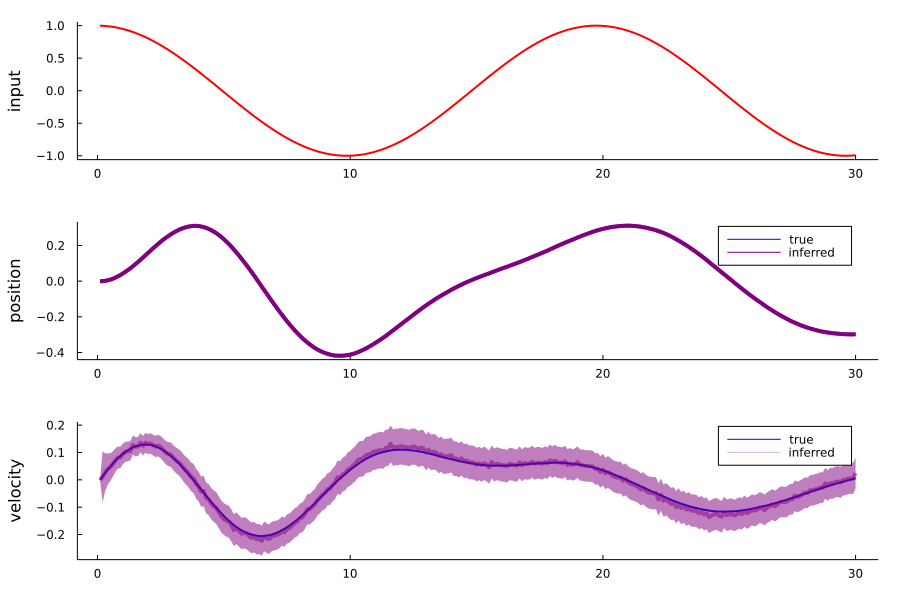

In [119]:
# Inputs
p301 = plot(t, input[1:T], color="red", linewidth=2, ylabel="input", label="")

# Position
p302 = plot(t, states[:,1], color="blue", linewidth=2, ylabel="position", label="true")
plot!(t, est_states[1][:,1], color="purple", label="inferred")
plot!(t, est_states[1][:,1], ribbon=sqrt.(est_states[2][:,1]), alpha=0.5, color="purple", label="")

# Velocity
p303 = plot(t, states[:,2], color="blue", linewidth=2, ylabel="velocity", label="true")
plot!(t, est_states[1][:,2], color="purple", label="inferred", alpha=0.3)
plot!(t, est_states[1][:,2], ribbon=sqrt.(est_states[2][:,2]), alpha=0.3, color="purple", label="")

plot(p301, p302, p303, layout=(3,1), size=(900,600))

The position of the oscillator is well tracked, but the velocity is harder to estimate.

#### Visualize 1-step ahead prediction errors

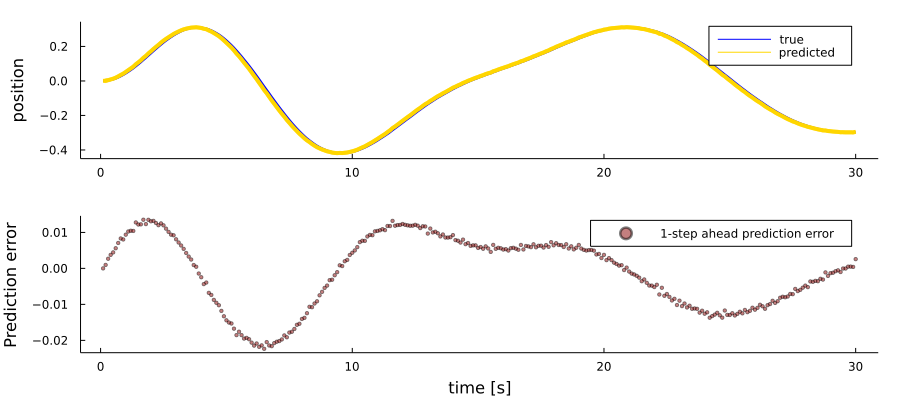

In [120]:
# Plot true states and 1-step ahead predictions
p401 = plot(t, states[:,1], color="blue", linewidth=2, ylabel="position", label="true")
plot!(t, post_preds[1][2:T+1,1], color="gold", label="predicted")
plot!(t, post_preds[1][2:T+1,1], ribbon=sqrt.(post_preds[2][2:T+1,1,1]), alpha=0.5, color="gold", label="")

# Squared difference between 1-step ahead prediction and true states
p402 = scatter(t, post_preds[1][2:T+1,1] .- states[:,1], color="darkred", markersize=2, alpha=0.5, xlabel="time [s]", ylabel="Prediction error", label="1-step ahead prediction error")

plot(p401, p402, layout=(2,1), size=(900,400))

The 1-step ahead prediction errors show that the parameter estimates could still be improved.

## Active Inference agent

At its core, the Free Energy Principle is a theory for how the brain performs both perception (signal processing) and action (control). So far, we have treated the input signal as a known designed variable. However, we can also make the model (agent) choose inputs such that it reaches a designated goal. In the case of our oscillator, the agent will have to regulate its position.

#### Expected Free Energy

In order to choose an appropriate set of inputs, the agent must know how these inputs affect future positions. The generative model can be "unrolled" into the future to make state predictions. In this case, we fix the parameters to their current estimates and condition the recognition model on the input variable. The new recognition model becomes:

$$ q(y_t, z_t \mid u_t) = q(y_t \mid z_t) \ q(z_t \mid u_t) \, , $$

where $t > k$ indicates future time steps.

The FE functional for the future is called the "Expected Free Energy":

$$ \mathcal{G}[q] = \underbrace{\int q(y_t \mid z_t) \big[ \overbrace{ \int q(z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p(y_t, z_t \mid u_t, y_{1:k})} \ \mathrm{d}z_t }^{\text{$\mathcal{F}[q]\ $ if $y_t$ was observed}} \ \big] \ \mathrm{d}y_t}_{\text{expectation over future observation $y_t$}} \, ,$$
 
It can be shown that, under some conditions and for this specific model class, the EFE is upper bounded by two terms:

$$ \mathcal{G}[q] \leq \underbrace{\int q(y_t \mid u_t) \log \frac{q(y_t \mid u_t)}{p(y_t)} \ \mathrm{d}y_t}_{\text{risk}} \ \underbrace{- \int q(y_t \mid z_t, u_t) \log q(y_t \mid z_t, u_t)}_{\text{ambiguity}}  \, .$$

The "risk" term is a Kullback-Leibler divergence indicating how different the believed future observation $q(y_t \mid u_t)$ is from the goal state $p(y_t)$. The "ambiguity" term corresponds to the entropy over the future observation given inputs. In essense, the EFE is an objective function that balances selecting inputs that reduce the uncertainty on its future observation and selecting inputs that push the agent closer to its goal (exploration-exploitation). 

#### Minimizing EFE

The above formulation is for a single future time step. In practice, the input signal is often bounded which means we might not be able to reach the goal in a single step. But this EFE can be applied recursively to look further into the future. With it, a set of inputs (policy) can be selected that actually drives the agent towards the goal state.

Unfortunately, BIASlab has not obtained a message passing formulation for Expected Free Energy minimization yet. We therefore resort to a constrained gradient descent procedure each time step.

In [121]:
function EFE(action, state_k, goal_state, params; Δt=1., time_horizon=1)
    "Expected Free Energy"
     
    # Unpack goal state
    μ_star = goal_state[1]
    Σ_star = goal_state[2]
    
    # Unpack prior state     
    μ_tmin1 = mn(state_k)
    Σ_tmin1 = cv(state_k)

    # Unpack model parameters
    θ, η, τ, ξ = params
    
    cEFE = 0
    for t in 1:time_horizon
        
        # State transition
        μ_t = A(θ)*μ_tmin1 + B(η)*action[t]
        Σ_t = A(θ)*Σ_tmin1*A(θ)' + Q(τ)

        # Predicted observation 
        μ_y = C*μ_t
        Σ_y = C*Σ_t*C' .+ inv(ξ)

        # Ambiguity represents conditional entropy of future observation given state
        ambiguity = 0.5(log2π + log(det(inv(ξ))) - 1)
        
        # Risk represents KL-divergence between marginal future observation and goal prior
        risk = 0.5*(log(det(Σ_star)/det(Σ_y)) + 1 + (μ_y - μ_star)'*inv(Σ_star)*(μ_y - μ_star) + tr(inv(Σ_star)*Σ_y))
        
        # Accumulate EFE over future time steps
        cEFE += risk + ambiguity
        
        # Update previous state
        μ_tmin1 = μ_t
        Σ_tmin1 = Σ_t
        
    end
    return cEFE
end;

Implementing an active inference controller consists of ..
1. .. selecting inputs, given state and parameter estimates,
2. .. executing the selected input and making a new observation,
3. .. updating states and parameters, given the selected input and new observation.

In [ ]:
!! TODO: visualize EFE planning phase

### Experiment 0: full observability


In [148]:
# Trial time
T = 100
t = Δt.*(1:T)

# Planning time horizon
TT = 20;

# Set position
goal_state = (-0.8, 1e-8);

In [162]:
# Preallocation
input = zeros(T,)
states = zeros(T,2)
output = zeros(T,)

# Set mean of initial state prior
states[1,:] = [1., 0.]

# Initialize constraints
constraints = Dict()

# Store estimated states
est_states = (zeros(T,2), zeros(T,2))

anim = @animate for k = 2:T
    
    "Select input"

    # Pack parameters estimated by model
    model_params = (θ_true, η_true, τ_true, ξ_true)

    # Objective function
    G(u_t) = EFE(u_t, marginals[:z_k], goal_state, model_params, Δt=Δt, time_horizon=TT)

    # Miminimize EFE
    results = optimize(G, -10, 10, zeros(TT,), Fminbox(LBFGS()); autodiff=:forward)

    # Execute first planned action only
    input[k] = Optim.minimizer(results)[1]
    
    "Execute input"
    
    # Execute input and observe output
    output[k], states[k,:] = sim_sys(input[k], states[k-1,:], sys_params)
    
    "Update state and model params"
    
    # Update constraints
    constraints = Dict(:y_k => output[k],
                       :u_k => input[k],
                       :m_kmin1 => mn(marginals[:z_k]),
                       :w_kmin1 => pc(marginals[:z_k]),
                       :m_θ => θ_true,
                       :w_θ => 1e3*I(2),
                       :m_η => η_true,
                       :w_η => 1e3*I(2),
                       :a_τ => τ_true,
                       :b_τ => 1e0)

    for _ = 1:10
        
        # Update state factors
        stepz_k!(constraints, marginals)
        stepz_kmin1!(constraints, marginals)
    
    end    
    
    # Store state estimates
    est_states[1][k,:] = mn(marginals[:z_k])
    est_states[2][k,:] = diag(cv(marginals[:z_k]))
    
    # Plot selected inputs
    p501 = plot(t[1:k], input[1:k], color="red", ylabel="inputs", xlims=[1,t[end]])

    # Plot position
    p502 = scatter(t[1:k], output[1:k], color="black", markersize=3, alpha=0.8, label="observed", ylabel="position", xlims=[1,t[end]])
    plot!(t[1:k], est_states[1][1:k,1], ribbon=sqrt.(est_states[2][1:k,1]), color="purple", label="inferred")
    plot!(t[1:k], goal_state[1]*ones(k,), alpha=0.3, color="green", label="goal state", ylims=[-1.5, 1.5])

    plot(p501, p502, layout=(2,1), size=(900,600))
    
end

Animation("/tmp/jl_dBhmmC", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000090.png", "000091.png", "000092.png", "000093.png", "000094.png", "000095.png", "000096.png", "000097.png", "000098.png", "000099.png"])

┌ Info: Saved animation to 
│   fn = /home/wmkouw/syndr/Wouter/Onderzoek/Demonstraties/tue/actinf-oscillator/figures/controller-exp0_knownparams.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Demonstraties/tue/actinf-oscillator/figures/controller-exp0_knownparams.gif")
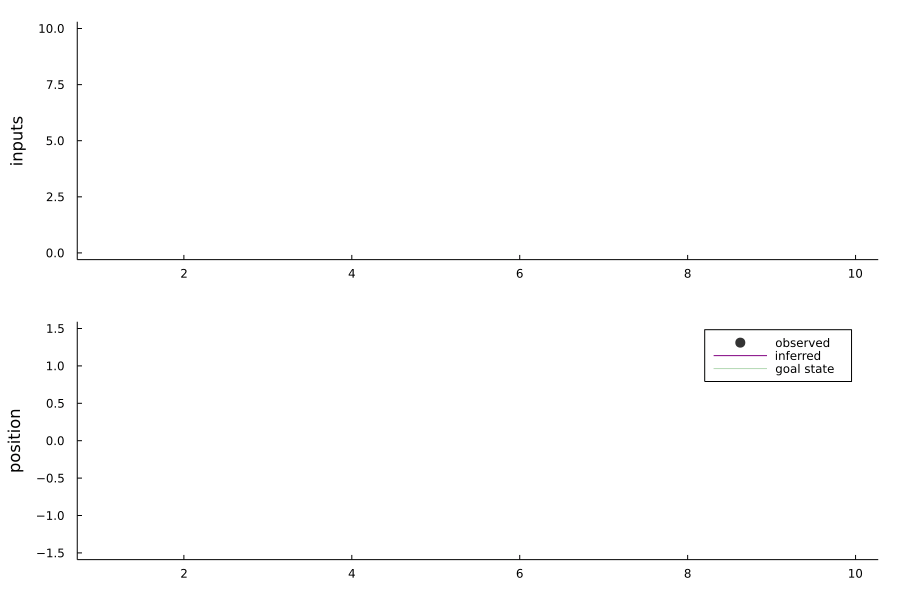

In [163]:
gif(anim, "figures/controller-exp0_knownparams.gif", fps=3)

#### Visualize selected inputs, actual outputs, and states inferred by the agent

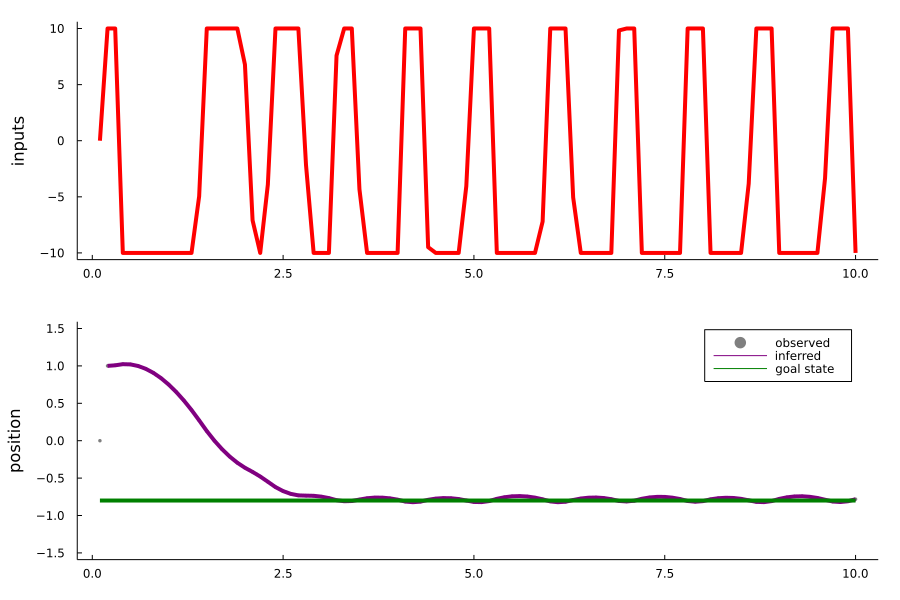

In [164]:
# Plot selected inputs
p501 = plot(t, input, color="red", ylabel="inputs", label="")

# Plot position
p502 = scatter(t, output, color="black", markersize=2, alpha=0.5, label="observed", ylabel="position")
plot!(t[2:T], est_states[1][2:T,1], color="purple", label="inferred")
plot!(t[2:T], est_states[1][2:T,1], ribbon=sqrt.(est_states[2][2:T,1]), color="purple", label="")
plot!(t, goal_state[1]*ones(T,), color="green", label="goal state", ylims=[-1.5, 1.5])

plot(p501, p502, layout=(2,1), size=(900,600))

### Experiment 1: initialize at true params


In [168]:
# Trial time
T = 100
t = Δt.*(1:T)

# Planning time horizon
TT = 30;

# Set position
goal_state = (-0.8, 1e-8);

In [169]:
# Set marginals
marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=θ_true, w=I(2))
marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=η_true, w=1.)
marginals[:τ] = ProbabilityDistribution(Univariate, Gamma, a=τ_true, b=1e0);

In [170]:
# Preallocation
input = zeros(T,)
states = zeros(T,2)
output = zeros(T,)

# Set mean of initial state prior
states[1,:] = [1., 0.]

# Initialize constraints
constraints = Dict()

# Store estimated states
est_states = (zeros(T,2), zeros(T,2))

anim = @animate for k = 2:T
    
    "Select input"

    # Pack parameters estimated by model
    model_params = (mn(marginals[:θ]), mn(marginals[:η]), mn(marginals[:τ]), ξ_true)

    # Objective function
    G(u_t) = EFE(u_t, marginals[:z_k], goal_state, model_params, Δt=Δt, time_horizon=TT)

    # Miminimize EFE
    results = optimize(G, -10, 10, zeros(TT,), Fminbox(LBFGS()); autodiff=:forward)

    # Execute first planned action only
    input[k] = Optim.minimizer(results)[1]
    
    "Execute input"
    
    # Execute input and observe output
    output[k], states[k,:] = sim_sys(input[k], states[k-1,:], sys_params)
    
    "Update state and model params"
    
    # Update constraints
    constraints = Dict(:y_k => output[k],
                       :u_k => input[k],
                       :m_kmin1 => mn(marginals[:z_k]),
                       :w_kmin1 => pc(marginals[:z_k]),
                       :m_θ => mn(marginals[:θ]),
                       :w_θ => pc(marginals[:θ]),
                       :m_η => mn(marginals[:η]),
                       :w_η => pc(marginals[:η]),
                       :a_τ => marginals[:τ].params[:a],
                       :b_τ => marginals[:τ].params[:b])

    for _ = 1:10
        
        # Update parameters
        stepθ!(constraints, marginals)
        stepη!(constraints, marginals)
        stepτ!(constraints, marginals)
        
        # Update state factors
        stepz_k!(constraints, marginals)
        stepz_kmin1!(constraints, marginals)
    
    end    
    
    # Store state estimates
    est_states[1][k,:] = mn(marginals[:z_k])
    est_states[2][k,:] = diag(cv(marginals[:z_k]))
    
    # Plot selected inputs
    p501 = plot(t[1:k], input[1:k], color="red", ylabel="inputs", xlims=[1,t[end]])

    # Plot position
    p502 = scatter(t[1:k], output[1:k], color="black", markersize=3, alpha=0.8, label="observed", ylabel="position", xlims=[1,t[end]])
    plot!(t[1:k], est_states[1][1:k,1], ribbon=sqrt.(est_states[2][1:k,1]), color="purple", label="inferred")
    plot!(t[1:k], goal_state[1]*ones(k,), alpha=0.3, color="green", label="goal state", ylims=[-1.5, 1.5])

    plot(p501, p502, layout=(2,1), size=(900,600))
    
end

Animation("/tmp/jl_ijbbrC", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000090.png", "000091.png", "000092.png", "000093.png", "000094.png", "000095.png", "000096.png", "000097.png", "000098.png", "000099.png"])

┌ Info: Saved animation to 
│   fn = /home/wmkouw/syndr/Wouter/Onderzoek/Demonstraties/tue/actinf-oscillator/figures/controller-exp1_inittrue.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Demonstraties/tue/actinf-oscillator/figures/controller-exp1_inittrue.gif")
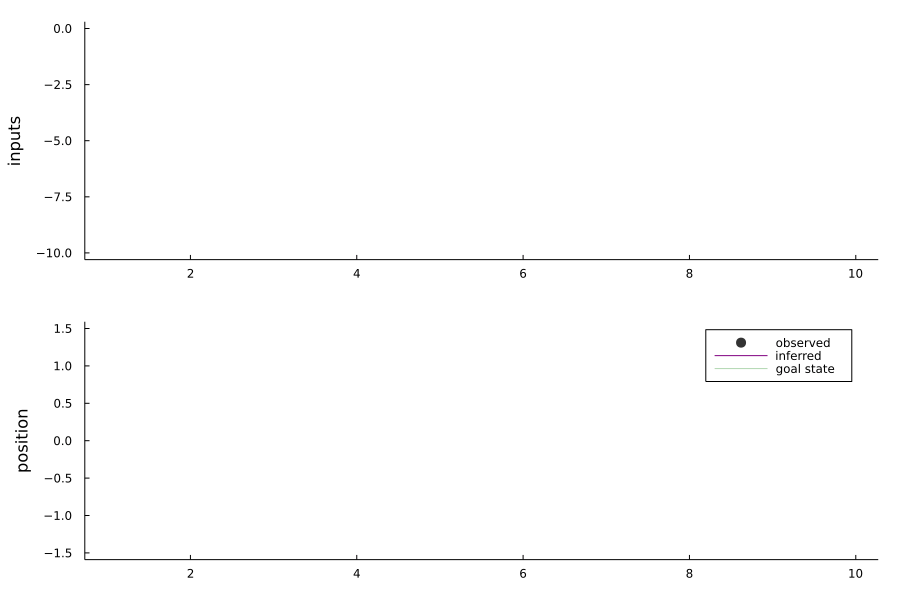

In [171]:
gif(anim, "figures/controller-exp1_inittrue.gif", fps=3)

#### Visualize selected inputs, actual outputs, and states inferred by the agent

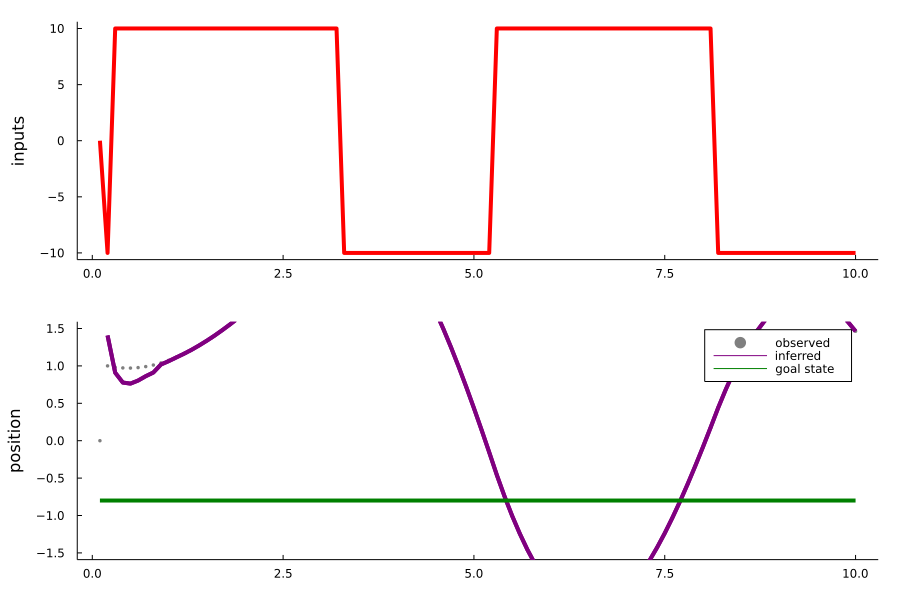

In [172]:
# Plot selected inputs
p501 = plot(t, input, color="red", ylabel="inputs", label="")

# Plot position
p502 = scatter(t, output, color="black", markersize=2, alpha=0.5, label="observed", ylabel="position")
plot!(t[2:T], est_states[1][2:T,1], color="purple", label="inferred")
plot!(t[2:T], est_states[1][2:T,1], ribbon=sqrt.(est_states[2][2:T,1]), color="purple", label="")
plot!(t, goal_state[1]*ones(T,), color="green", label="goal state", ylims=[-1.5, 1.5])

plot(p501, p502, layout=(2,1), size=(900,600))

### Experiment 2: initialize randomly


In [173]:
# Trial time
T = 200
t = Δt.*(1:T)

# Planning time horizon
TT = 30;

# Set position
goal_state = (-0.8, 1e-8);

In [174]:
# Set marginals
marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=randn(2), w=1e-3*I(2))
marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=randn(1)[1], w=1e-3*1.)
marginals[:τ] = ProbabilityDistribution(Univariate, Gamma, a=rand(1)[1], b=1e0);

In [175]:
# Preallocation
input = zeros(T,)
states = zeros(T,2)
output = zeros(T,)

# Set mean of initial state prior
states[1,:] = [1., 0.]

# Initialize constraints
constraints = Dict()

# Store estimated states
est_states = (zeros(T,2), zeros(T,2))

anim = @animate for k = 2:T
    
    "Select input"

    # Pack parameters estimated by model
    model_params = (mn(marginals[:θ]), mn(marginals[:η]), mn(marginals[:τ]), ξ_true)

    # Objective function
    G(u_t) = EFE(u_t, marginals[:z_k], goal_state, model_params, Δt=Δt, time_horizon=TT)

    # Miminimize EFE
    results = optimize(G, -10, 10, zeros(TT,), Fminbox(LBFGS()); autodiff=:forward)

    # Execute first planned action only
    input[k] = Optim.minimizer(results)[1]
    
    "Execute input"
    
    # Execute input and observe output
    output[k], states[k,:] = sim_sys(input[k], states[k-1,:], sys_params)
    
    "Update state and model params"
    
    # Update constraints
    constraints = Dict(:y_k => output[k],
                       :u_k => input[k],
                       :m_kmin1 => mn(marginals[:z_k]),
                       :w_kmin1 => pc(marginals[:z_k]),
                       :m_θ => mn(marginals[:θ]),
                       :w_θ => pc(marginals[:θ]),
                       :m_η => mn(marginals[:η]),
                       :w_η => pc(marginals[:η]),
                       :a_τ => marginals[:τ].params[:a],
                       :b_τ => marginals[:τ].params[:b])

    for _ = 1:10
        
        # Update parameters
        stepθ!(constraints, marginals)
        stepη!(constraints, marginals)
        stepτ!(constraints, marginals)
        
        # Update state factors
        stepz_k!(constraints, marginals)
        stepz_kmin1!(constraints, marginals)
    
    end    
    
    # Store state estimates
    est_states[1][k,:] = mn(marginals[:z_k])
    est_states[2][k,:] = diag(cv(marginals[:z_k]))
    
    # Plot selected inputs
    p501 = plot(t[1:k], input[1:k], color="red", ylabel="inputs", xlims=[1,t[end]])

    # Plot position
    p502 = scatter(t[1:k], output[1:k], color="black", markersize=3, alpha=0.8, label="observed", ylabel="position", xlims=[1,t[end]])
    plot!(t[1:k], est_states[1][1:k,1], ribbon=sqrt.(est_states[2][1:k,1]), color="purple",label="inferred")
    plot!(t[1:k], goal_state[1]*ones(k,), alpha=0.3, color="green", label="goal state", ylims=[-1.5, 1.5])

    plot(p501, p502, layout=(2,1), size=(900,600))
    
end

Animation("/tmp/jl_yXEMVy", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000190.png", "000191.png", "000192.png", "000193.png", "000194.png", "000195.png", "000196.png", "000197.png", "000198.png", "000199.png"])

┌ Info: Saved animation to 
│   fn = /home/wmkouw/syndr/Wouter/Onderzoek/Demonstraties/tue/actinf-oscillator/figures/controller-exp2_initrandom.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Demonstraties/tue/actinf-oscillator/figures/controller-exp2_initrandom.gif")
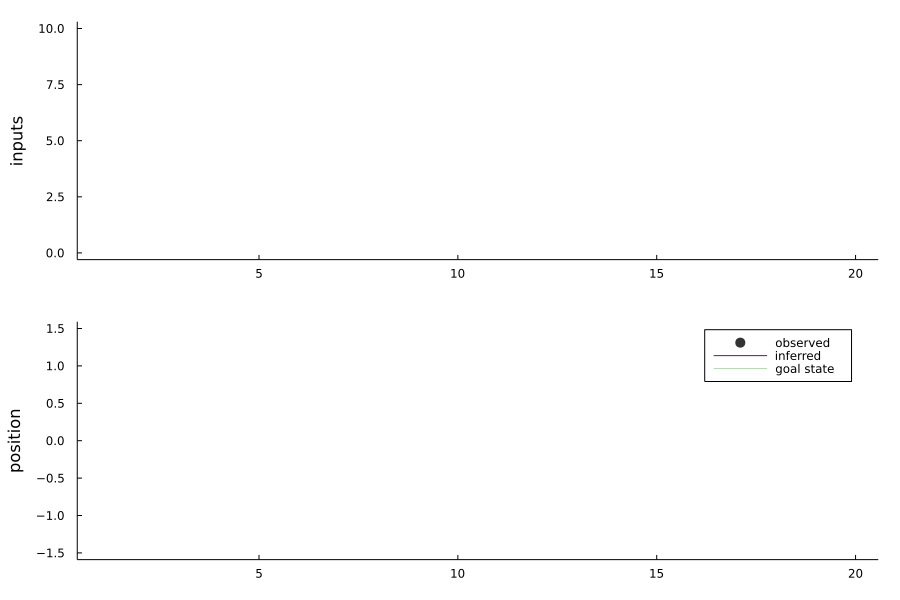

In [176]:
gif(anim, "figures/controller-exp2_initrandom.gif", fps=3)

#### Visualize selected inputs, actual outputs, and states inferred by the agent

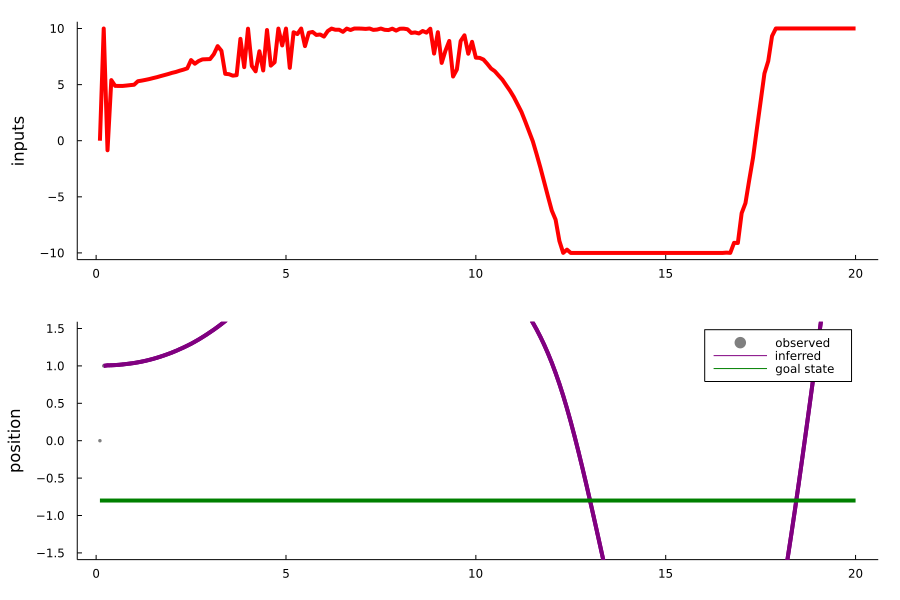

In [177]:
# Plot selected inputs
p501 = plot(t, input, color="red", ylabel="inputs", label="")

# Plot position
p502 = scatter(t, output, color="black", markersize=2, alpha=0.5, label="observed", ylabel="position")
plot!(t[2:T], est_states[1][2:T,1], color="purple", label="inferred")
plot!(t[2:T], est_states[1][2:T,1], ribbon=sqrt.(est_states[2][2:T,1]), color="purple", label="")
plot!(t, goal_state[1]*ones(T,), color="green", label="goal state", ylims=[-1.5, 1.5])

plot(p501, p502, layout=(2,1), size=(900,600))